## A good title

This notebook includes the final results of the master thesis "XXX" by Martin Jacobson, 2021-05.

The structure is the following: 
1. Load datasets and visualize them in two dimensions. 
2. With ELM and KFoldCross validation showcase difference in MCC between them.
3. Get Feature importance form Extra Trees or Random Forest.
4. For each group of models on a set of datasets, Loop following steps. Grouping of model as; 
    (Multilayer Perceptron, ELM)
    (ELSVM, RUTSVM, CS-SVM)
    (Random Forests, Decision Tree, Bagging Decision Trees, Extra Trees)    
    2. Test PCA reduction, increasing one dimension at a time. 
    2. Adding one feature at at time, train top N models for each classifier and get new results.
    3. With a subset of features train models with sampling. Over-Under... etc..  
    4. Chaninging (train-test)-validation splits
    5. Showcase training times for models by using one dataset with increasing number of samples.     
    6. Train and optimize. Visualize Recall-Precision plot and MCC, with std.

Homebuilt functions can be viewed in 'funs.py'

In [1]:
'Import homebuilt functions'
from funs import *

'Import Classifiers'
from ELM import ELM 

'Import train test splits'
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
'Import plotting'
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [7]:
Datasets = {      
    'Standard':'no_agg_encoded',   # Jan-Feb
    'Aggregated 1':'agg0_encoded', # with frauds
    'Aggregated 2':'agg1_encoded', # with trans last 6,3,1m 
    'Aggregated 3':'agg2_encoded', # Periodic aggregated
    'Aggregated 4':'agg3_encoded', # Reciver, country, and bic specific no.trans, no.frauds..
    'Aggregated 5':'agg5_encoded', # Reciver, country, and bic specific no.trans, no.frauds..
    'Aggregated 1+2':'agg01_encoded',
    'Aggregated 1+2+4':'agg013_encoded',
    'Aggregated 1+2+3+4':'agg0123_encoded',    
    'Dal Pozzolo Dataset':'DAL_P',
    'All trans':'SHB_3_wR_wE',     # All transactions Jan-Mar
    'Standard 2':'OneTypeTrans3_wR_wE', # Jan-Mar
}
folder = "/Users/Martin/Documents/Exjobb_Handelsbanken/Data"

## Visualize Datasets 

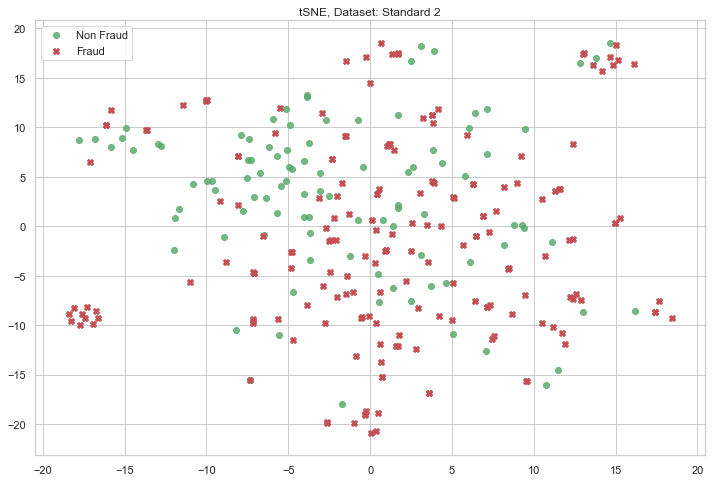

In [4]:
save_folder = 'Plots/visualize_datasets'
tempDataset = {'Standard':'no_agg_encoded'}

key = 'Standard 2'
for i in [1]:
# for i,key in enumerate(Datasets.keys()):
    df = read_data(Datasets[key],folder)
    mask = df['Class'] == 0
    n = min(100,mask[mask].shape[0]-1)
#     n = min(3000,mask[mask].shape[0]-1)
    
    non_fraud = df[mask].sample(n)
    fraud = df[~mask]
    df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

    X,Y = get_sets(df.copy())
    X,_ = scale_data(X,'Standard')    
    
    tsne_plot(X, Y, 
              save_name="{}/{}.png".format(save_folder,key),
              title='tSNE, Dataset: {}'.format(key),
              save=True, show=True, verbose=False,
              alpha_F=1, alpha_G=0.8,
              marker_F='X', marker_G='o'
              )

## Feature Importance

Correlation plots first.

Difference between my Datasets and Pozzolo's is that his is already gone through a PCA transformation.

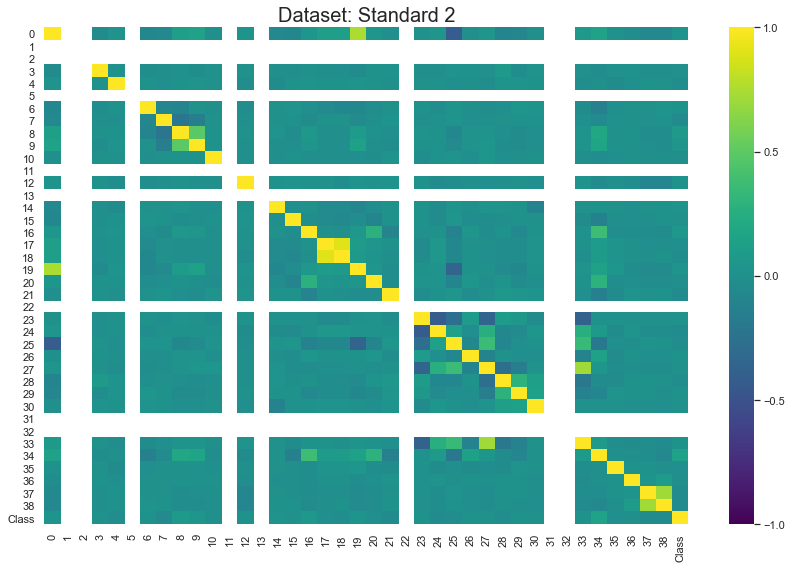

In [5]:
save_folder = 'Plots/Correlation'
key = 'Standard 2'
for i in [1]:
# for i,key in enumerate(Datasets.keys()):
    df = read_data(Datasets[key],folder)
    f = plt.figure(figsize=(12, 8))
      
    corr = df.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
               vmin=-1,
               vmax=1,
               cmap='viridis',
               center=0,
               cbar_kws={"ticks":[-1,-.5,0,.5,1]},
               )
    plt.title('Dataset: {}'.format(key),fontdict ={'fontsize':20})
    plt.tight_layout()
    plt.savefig('{}/{}.png'.format(save_folder,key))
    plt.show()

Create a dictionary for each dataset which will store needed information.

In [6]:
set_dict = {}
for key in Datasets.keys():
    set_dict[key] = {}
    set_dict[key]['filename'] = Datasets[key]

Feature Importance scores.
We are training one model one the WHOLE dataset. This is because it is very important to not lose any information for each feature. A subset could over-/under-estimate each feature and would make the decision to remove features less prudent.

We train two identical Random Forest models with different split criterion; 'gini' and 'entropy'. Afterwards, since each criterion yields results within the same range, we average the measures to determine the 'True' importance order. We do not expect to gain to much by averaging. Bad features will rank low for both, but a bad feature might be super bad for one but not as much by the other.


Standard
Aggregated 1
Aggregated 2
Aggregated 3
Aggregated 4
Aggregated 1+2
Aggregated 1+2+4
Aggregated 1+2+3+4
Dal Pozzolo Dataset


KeyboardInterrupt: 

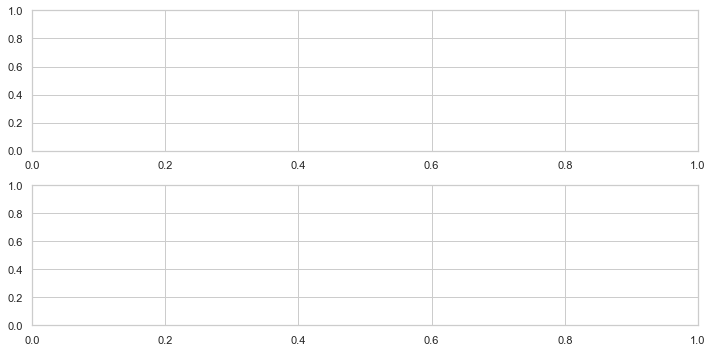

In [10]:
save_folder = 'Plots/Feature Importance'
# key = 'Standard 2'
for i,key in enumerate(Datasets.keys()):
    print(key)
    df = read_data(Datasets[key],folder)
    Y = df.pop('Class')
    evaluator= ['Extra','Decision','Random']
    evaluator = 'Random'
    
    fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=False,sharey=True)
    plt.tight_layout()
    col_order,importance = evaluate_features(df,Y,
                                             n_estimators=100,
                                             n_jobs=2,
                                             evaluator=evaluator,
                                            criterion='gini')
    col_order2,importance2 = evaluate_features(df,Y,
                                               n_estimators=100,
                                            n_jobs=2,
                                            evaluator=evaluator,
                                            criterion='entropy')
    
    temp = plot_feature_importance(col_order,importance,
                               sort=True,
                               ascending=False,
                               show=False,
                               ax= ax[0],
                            title_fontsize=10,
                            x_fontsize=10,
                            y_fontsize=10,
                            x_tick_size=10,
                            y_tick_size=10,
                               title='Dataset: {}, Evaluator: {}'.format(key,evaluator));    
    temp = plot_feature_importance(col_order2,importance2,
                               sort=True,
                               ascending=False,
                               show=False,
                               ax= ax[1],
                            title_fontsize=10,
                                x_fontsize=20,
                            y_fontsize=10,
                            x_tick_size=10,
                            y_tick_size=10,
                               title='Dataset: {}, Evaluator: {}'.format(key,evaluator));
    title='Dataset: {}, Evaluator: {}'.format(key,evaluator)
    ax[1].set_ylabel('')
    ax[0].set_ylabel('')
    ax[0].set_xlabel('')
    ax[0].title.set_text('Gini Scores')
    ax[1].title.set_text('Entropy Scores')
    fig.text(-0.05, 0.5, 'Importance weights',size=20, va='center', rotation='vertical')
    fig.text(0.3, 1.05, title,size=20)#, va='left')
    
    fig.savefig('{}/{}.png'.format(save_folder,key+'_gini_entorpy'), bbox_inches = "tight");
    
    order_df = pd.DataFrame()
    order_df.loc[:,'index'] = df.columns[col_order]
    order_df.set_index('index',inplace=True,drop=True)

    
    cols1 = df.columns[col_order]
    cols2 = df.columns[col_order2]
    order_df.loc[cols1,'Gini'] = importance
    order_df.loc[cols2,'Entropy'] = importance2
    
    order_df.sort_values('index',inplace=True)
    order_df.loc[:,'Average'] =  (order_df.loc[:,'Gini'] + order_df.loc[:,'Entropy']) / 2 
    order_df.sort_values('Average',inplace=True,ascending=False)

    col_order = order_df.index
    importance = order_df.loc[:,'Average'].values
    
    set_dict[key]['Features'] = {}
    set_dict[key]['Features']['Avg. Importance Scores'] = importance
    set_dict[key]['Features']['Importance Order'] = col_order
    
    fig0,ax = plot_feature_importance(col_order,importance,
                                sort=True,
                                ascending=False,
                                show=False,
                                title_fontsize=20,
                                x_fontsize=20,
                                y_fontsize=20,
                                x_tick_size=20,
                                y_tick_size=20,
                                title='Average Scores, Dataset: {}, Evaluator: {}'.format(key,evaluator));
    fig0.savefig('{}/{}.png'.format(save_folder,key))
    plt.close('all')

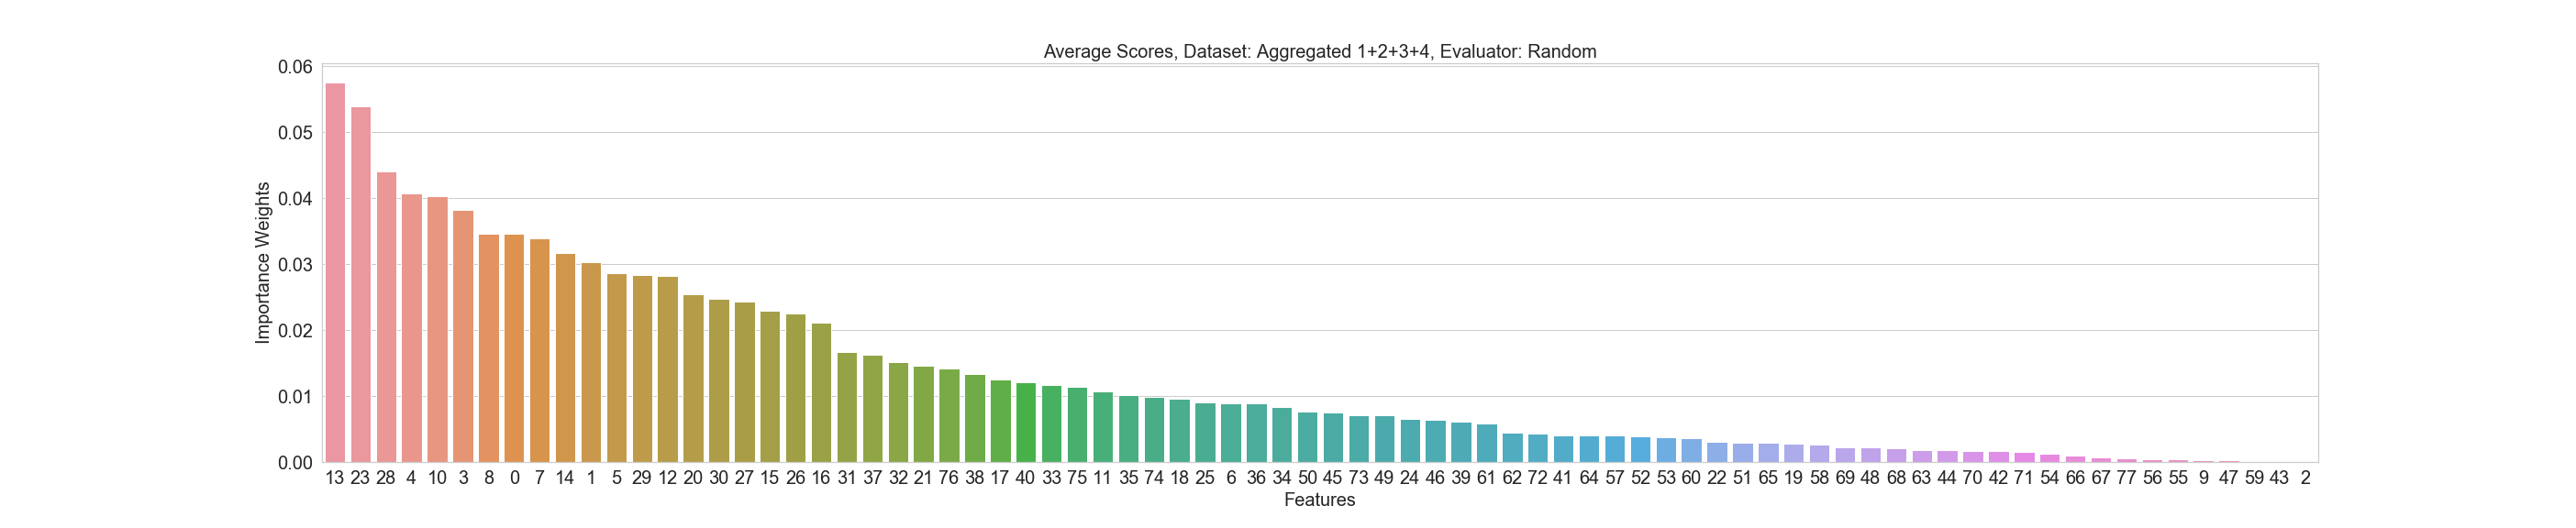

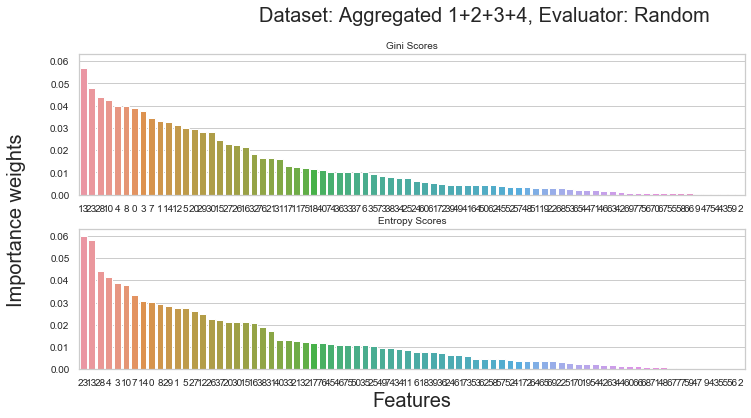

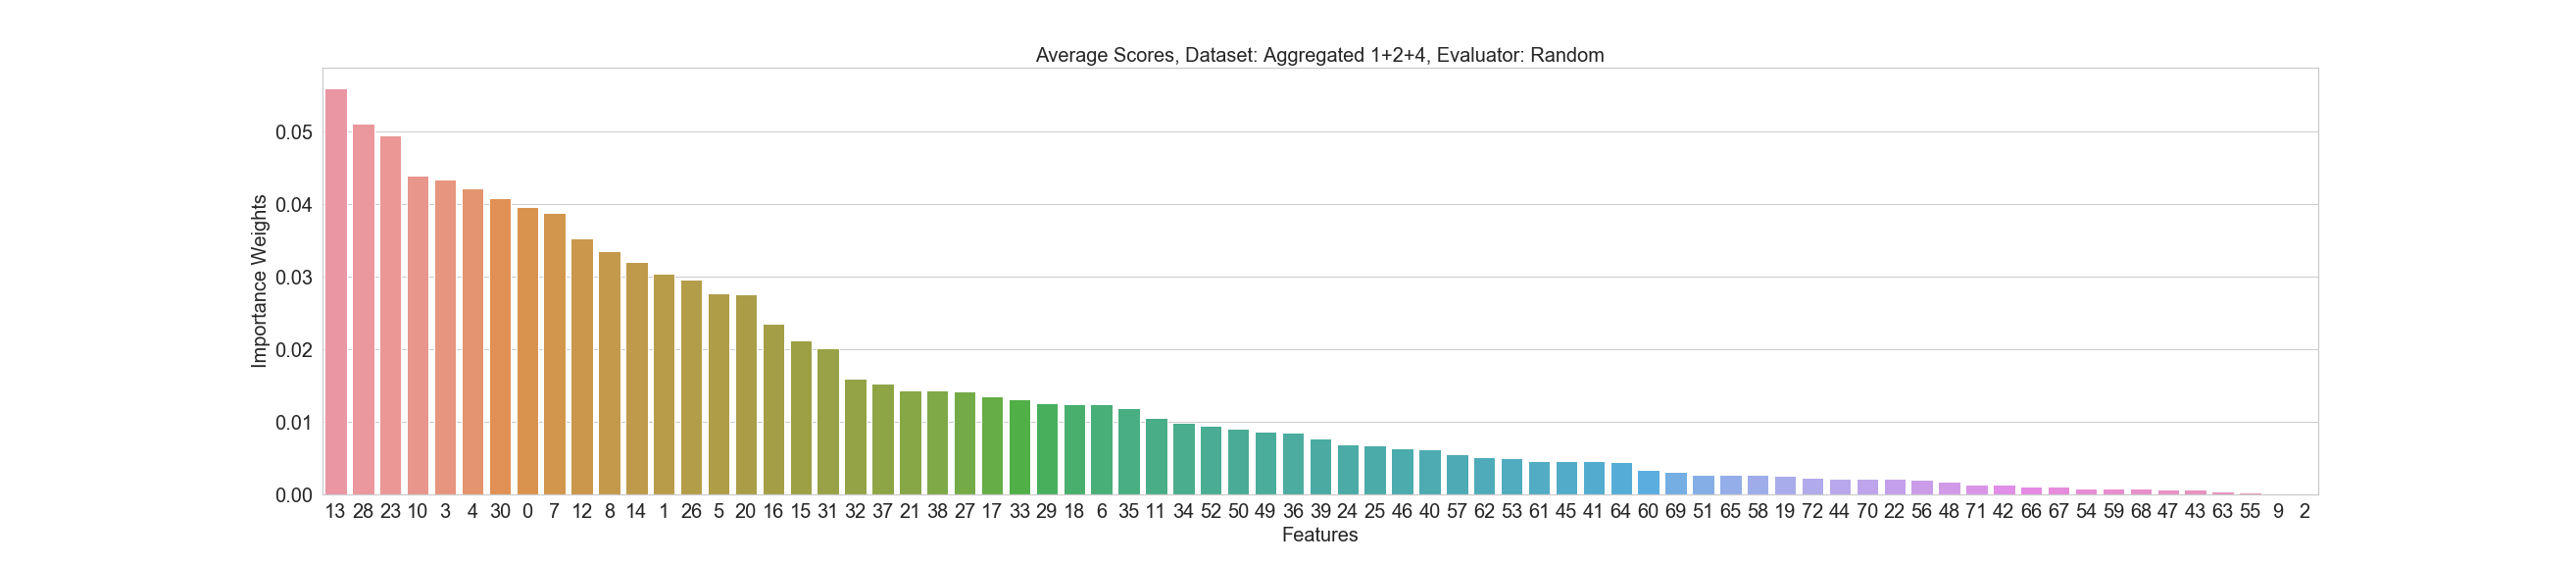

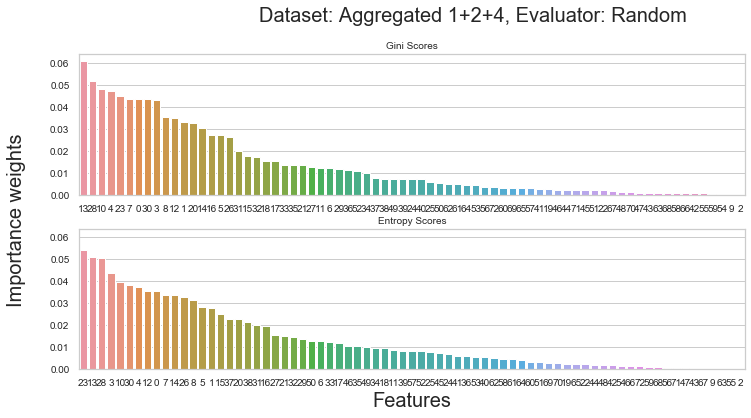

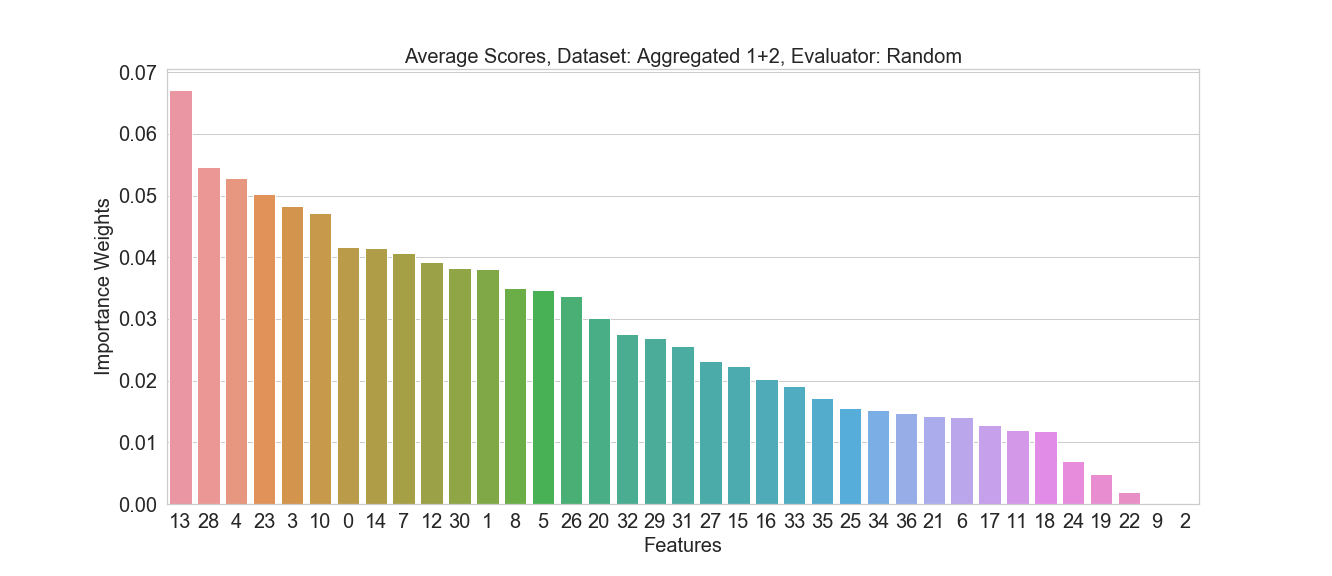

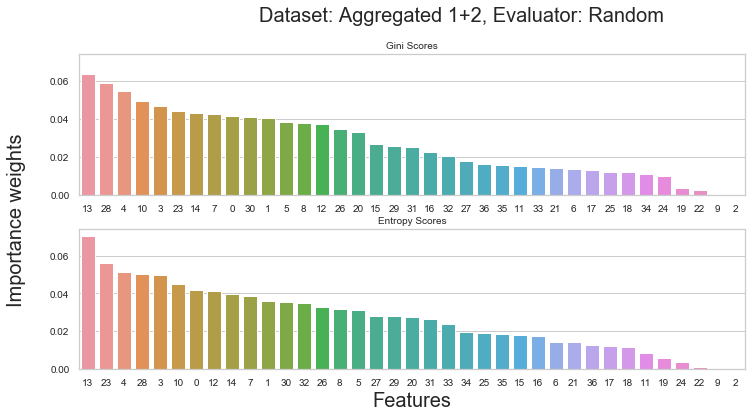

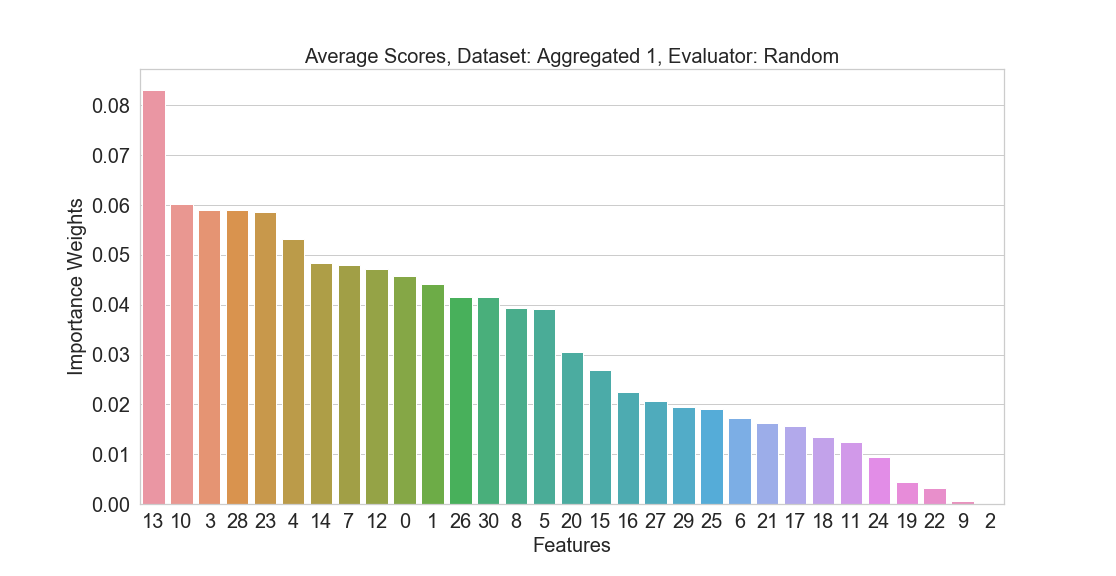

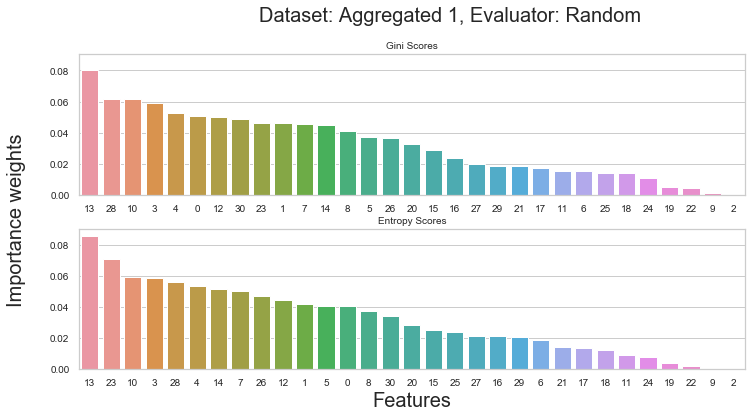

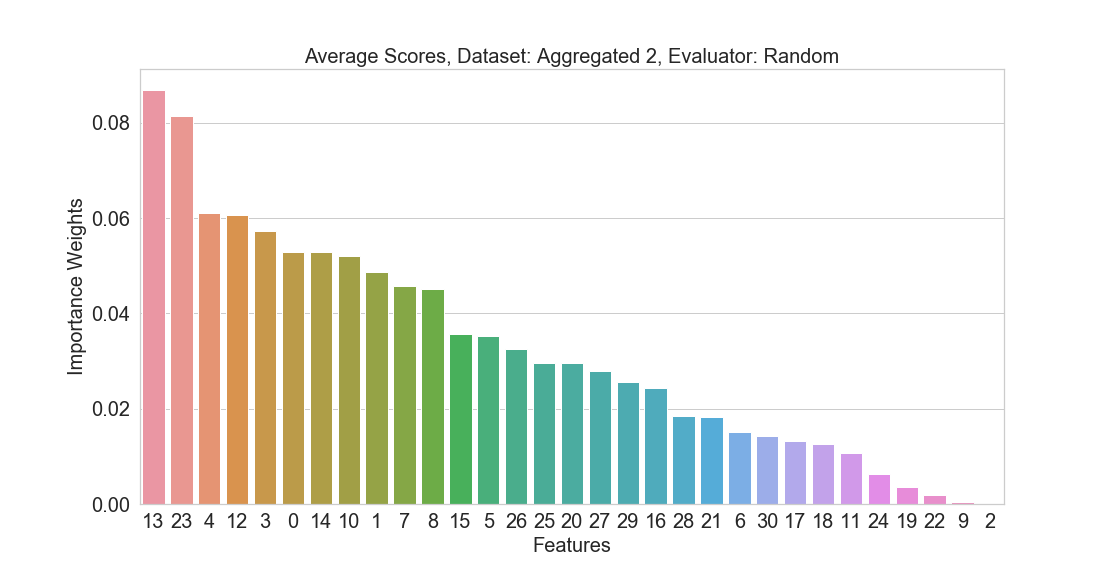

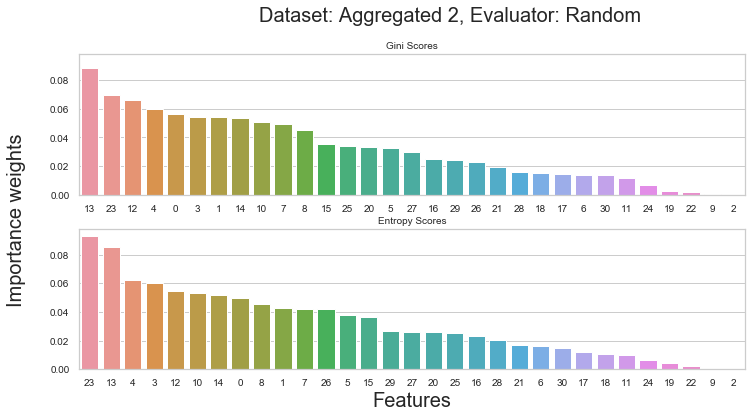

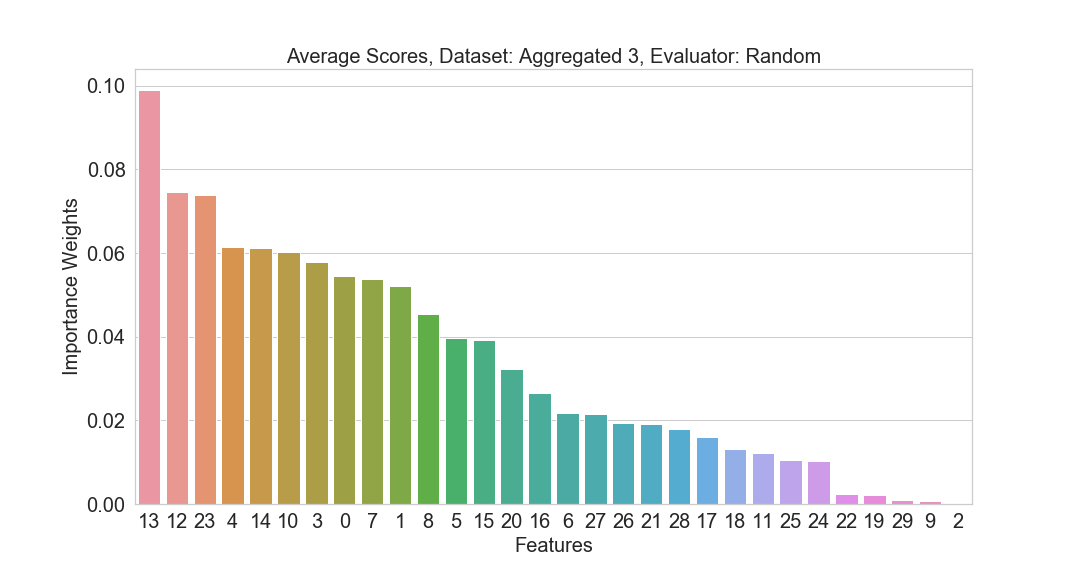

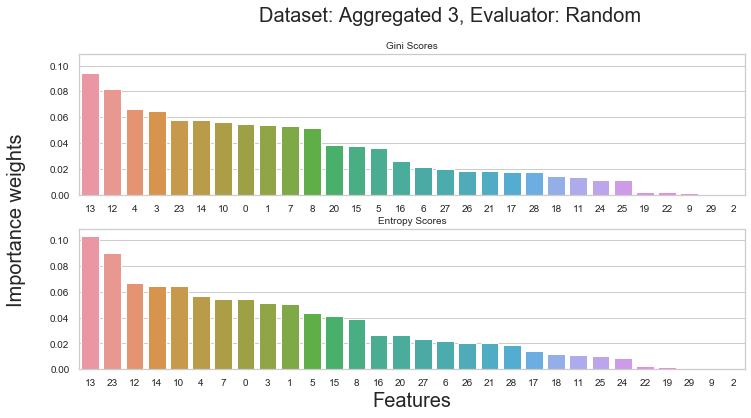

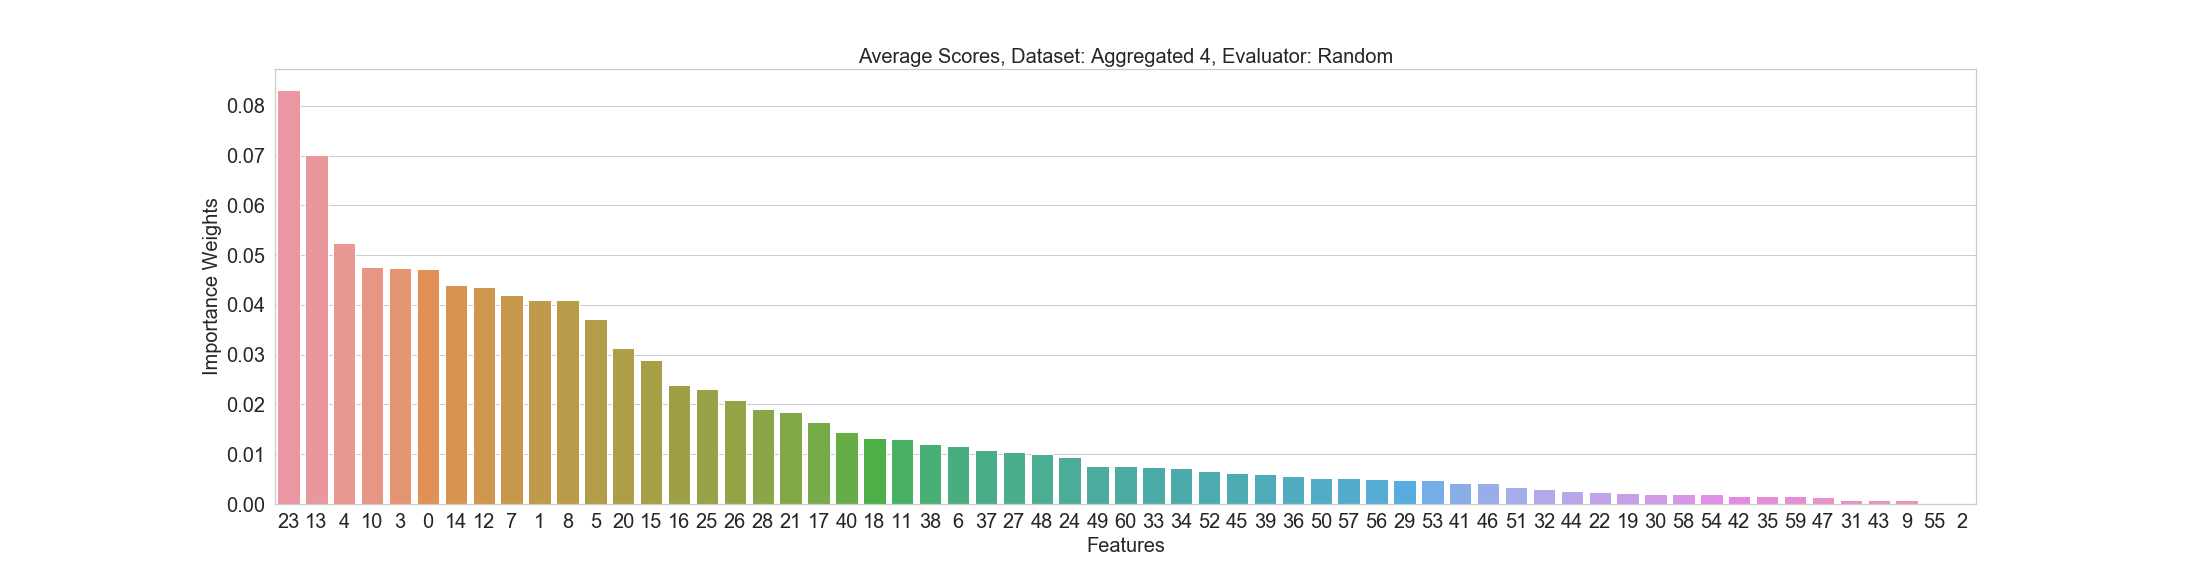

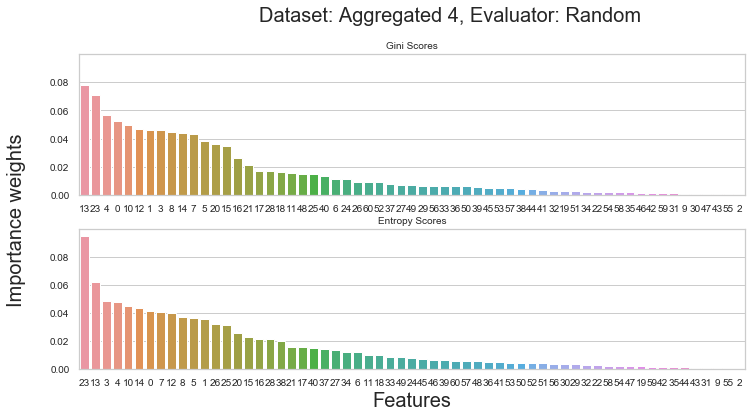

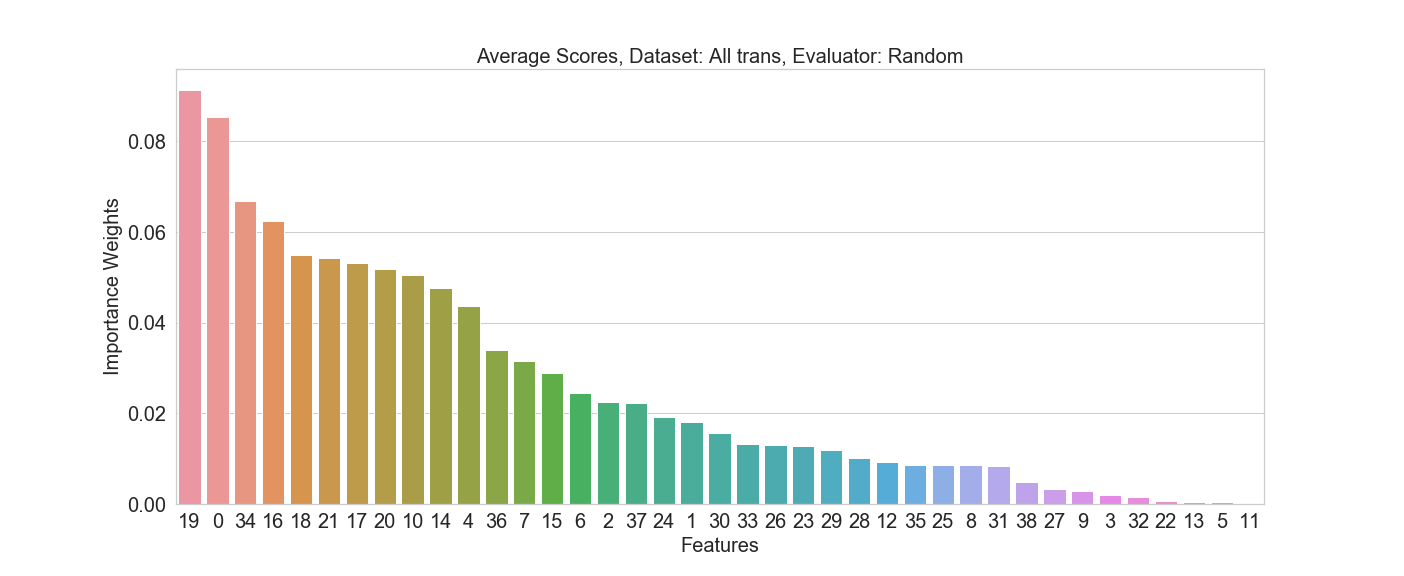

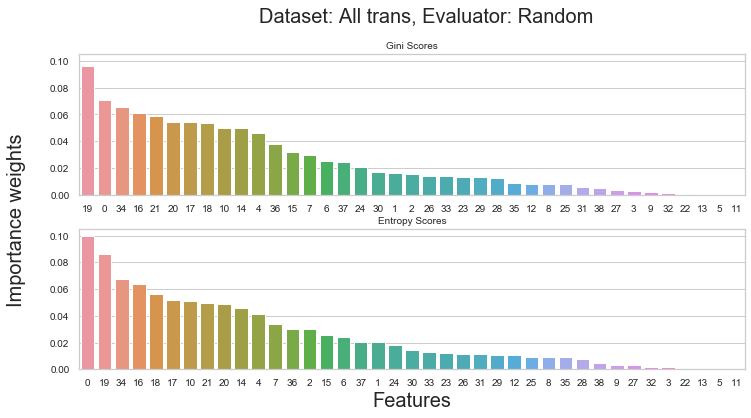

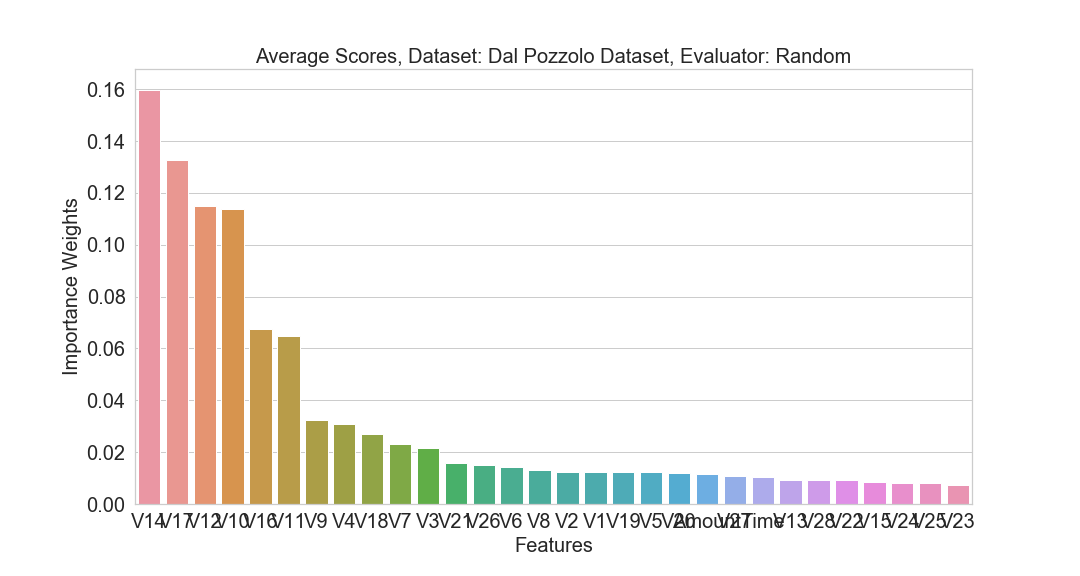

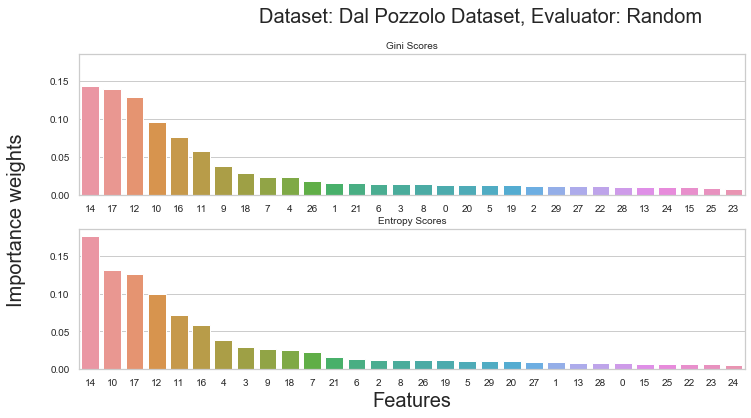

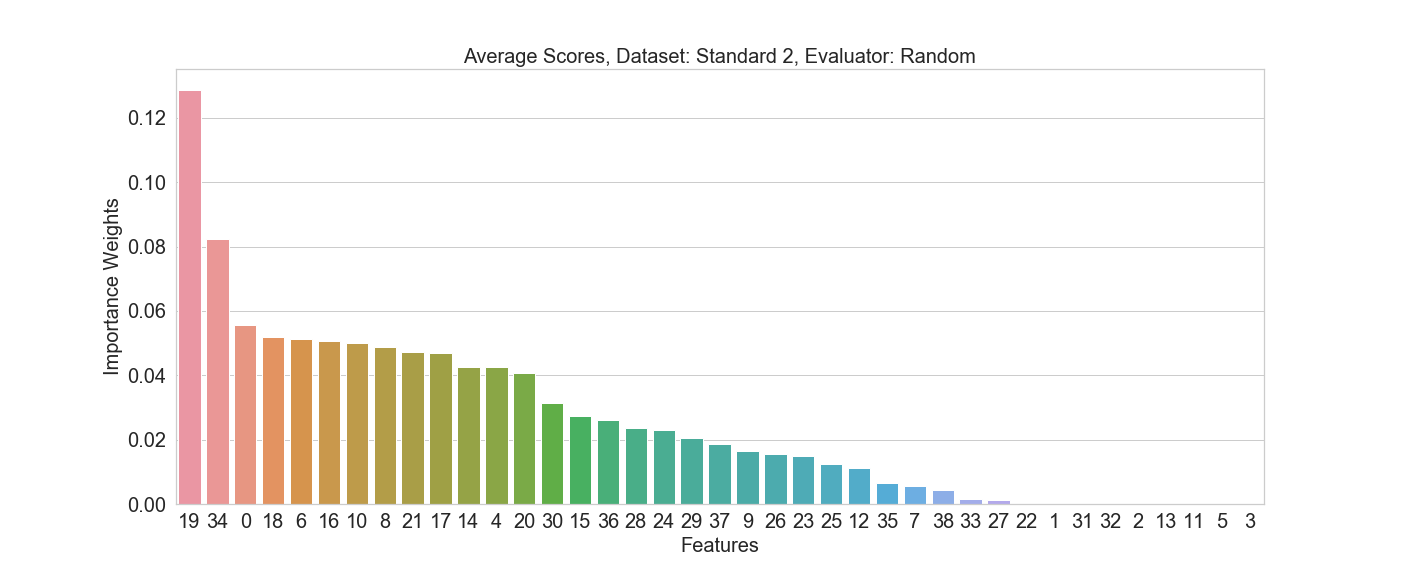

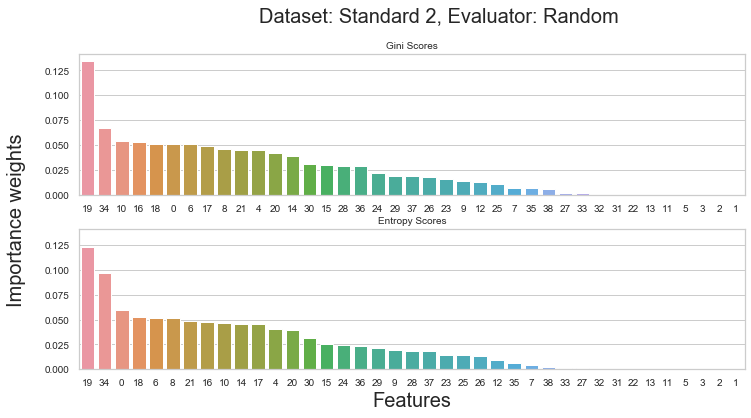

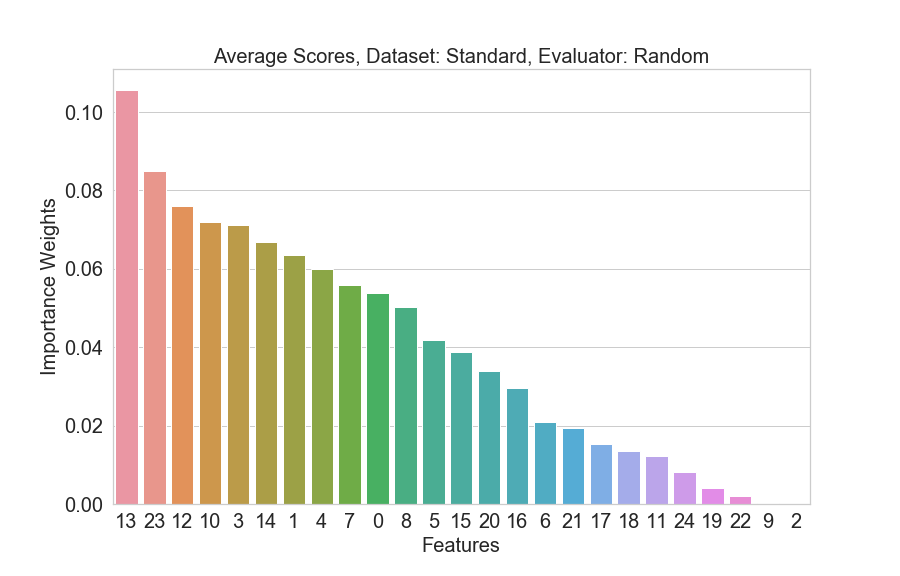

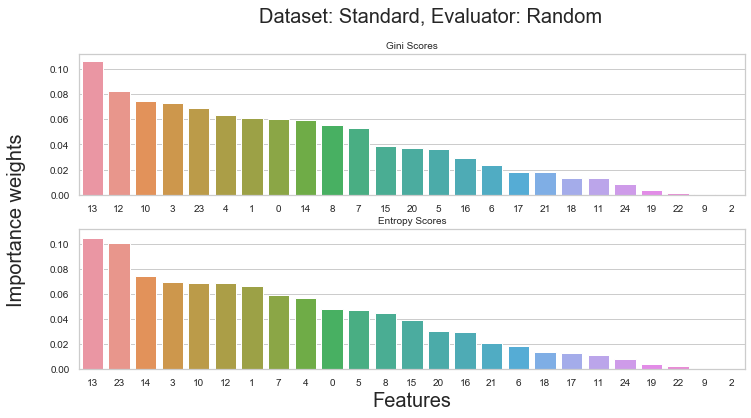

In [3]:
from IPython.display import Image, display
from os import listdir
from os.path import isfile, join



def view_folder(folder):    
    View_folder = '/Users/Martin/Documents/Exjobb final/'#Plots/Feature Importance/'
    onlyfiles = [f for f in listdir(View_folder) if isfile(join(View_folder, f))]
    for filename in onlyfiles:
        display(Image(filename=view_folder+'/{}'.format(filename)))
view_folder('Plots/ Feature Importance/')

In [ ]:
def run_feature_experiment(local_dict,key2, 
                          min_features = 10,
                          max_features = 45,
                          jump = 3,
                          scale = True,
                          do_PCA = False, # Cannot combine feature subset with do_PCA..
                          new_key = False,
                          feature_subset = False, 
                          SAMPLER_dict = {},
                          verbose = 1                       
                          ):
    for key in local_dict.keys():
        print(key)
        if new_key:
            local_dict[key][key2] = {}
        local_dict[key][key2]['Runs'] = {}
        local_dict[key][key2]['Runs']['Scores'] = {}
        local_dict[key][key2]['Runs']['All runs'] = {}
        
        filename = Datasets[key]
#         filename = local_dict[key]['filename']
        
        DF = read_data(filename,folder)

        Y = DF.pop('Class')    
        DF.loc[:,DF.dtypes == 'bool'] = DF.loc[:,DF.dtypes == 'bool'].astype(int)
    
        if feature_subset:            
            col_order = local_dict[key]['Features']['Importance Order'].values            
        
        no_feats=list(range(min_features,min(max_features,DF.shape[1]-1),jump))
        for i,n_features in enumerate(no_feats):
            df = DF.copy()
            if verbose > 0:
                print('{}/{}'.format(i+1,len(no_feats)))
            
            if feature_subset:
                df = df.loc[:,col_order[0:n_features]]
            
            Xtrain,Xtest,Ytrain,Ytest = train_test_split(df,Y.values,
                            train_size=0.5,
                            shuffle=False)
            
            Xtrain = Xtrain.values
            if scale:
                Xtrain,scaler = scale_data(Xtrain,'MinMax')
                Xtest= scaler.transform(Xtest.values)
                Xtrain = Xtrain.values
            if do_PCA:
                pca = PCA(n_components= n_features)
                Xtrain = pca.fit_transform(Xtrain)
                Xtest  = pca.transform(Xtest)
                
            if SAMPLER_dict:
                print('yoyo')
                sampler = SAMPLER_dict['sampler']
                sampling_strategy = SAMPLER_dict['strategy']
                sampler(sampling_strategy=sampling_strategy)
                Xtrain,Ytrain = sampler.fit_resample(Xtrain,Ytrain)

            if verbose >2:
                print(Xtrain.shape)
            mets = 0
            score_df = pd.DataFrame()
            for j in range(10):
                elm = ELM(m=128,w=10)#,type='wc') # 'standard 2'
                elm.fit(Xtrain,Ytrain)
                Ypreds = elm.predict(Xtest)
                met = getMetrics(Ytest,Ypreds)
                mets += met

                met.loc['Run'] = j+1
                score_df = score_df.append(met,ignore_index=True)

            if verbose > 2:
                print(mets/(j+1))
            local_dict[key][key2]['Runs']['Scores'][n_features] = mets / (j+1)
            local_dict[key][key2]['Runs']['All runs'][n_features] = score_df
    return local_dict

set_dict = run_feature_experiment(set_dict,'Features',
                                 feature_subset=True,
                                 scale=True,
                                 do_PCA = False,
                                 min_features = 1,
                                 max_features = 3,
                                 jump=1)
set_dict = run_feature_experiment(set_dict,'PCA reduction',do_PCA = True,new_key=True)

In [ ]:
def box_plot_4_dict(key2 = 'Features',x_col='No. PCA components',xlabel=None,save=True,folder='Plots'):
    if xlabel is None:
        xlabel = x_col        
    for key in set_dict.keys():
        bigg_df = pd.DataFrame()
        for i in set_dict[key][key2]['Runs']['All runs'].keys():
            set_dict[key][key2]['Runs']['All runs'][i].loc[:,x_col] = i
            bigg_df =pd.concat([bigg_df,set_dict[key][key2]['Runs']['All runs'][i]]).reset_index(drop=True)        
        set_dict[key][key2]['All runs DF'] = bigg_df
#         plt.tight_layout();
        fig,ax= plot_boxchart(bigg_df,title=key,x=x_col,xlabel=xlabel);
        if save: 
            fig.savefig('{}/{}_{}.png'.format(folder,key,x_col))

Investigating features and adding the best available feature may not produce an optimal feature set, though this is and should be seen as a good indicator of which features are actually good and (if) when the number of features starts to become a problem. A good generalization for all sets can not with good conscience be made. Rule of tumb's can be stated for each set, even these may not be good practice, due to overfitting or losing pivital data for specific cases.

The Extreme Learning Machine classifier have a huge variance, which in our case is good. Even if for some subset of features the estimator is more likely to overfit, the ELM will produce bad results. Which means that overfittness will be visiable mostly as; a higher score with a very narrow 0.15 to 25 percentile span. On the contrary a narrow band of 75 to 99.85 percentile .

In [ ]:
'Box plots for Features'
save_folder = 'Plots/Feature Reduction'
box_plot_4_dict(key2='Features',x_col='No. Features',folder=save_folder)

Now the PCA reduction plots. Here we note that the aggregated datasets have their score increased by using PCA with relativly many components. Even the sets 'Aggregated 2' and 'Aggregated 3' is more positively affected by PCA than 'Standard', 'All trans' and 'Standard 2'. An explanation could be that the Aggregated sets introduces features which are not only individually interesting, but even more interesting is the new relationship between aggregated features and aggregated features and ofcourse with the 'raw' features. PCA is reducing the dimensions by relating features to eachother, hence why aggregated sets may see a greated benefit.

In [ ]:
'Box plots for PCA reduction'
save_folder = 'Plots/Feature Reduction'
box_plot_4_dict(key2='PCA reduction',x_col='No. PCA components',folder=save_folder)


## Feature selection and PCA reduction

In [ ]:
key ='Standard 2'
from sklearn.decomposition import PCA

min_features = 15
max_features = 20
jump = 5
pca_reduction_set = [-3,-6]#,-9,-12]
for key in set_dict.keys():
    print(key)
    set_dict[key]['PCA n Features'] = {}
    set_dict[key]['PCA n Features']['Runs'] = {}
    set_dict[key]['PCA n Features']['Runs']['Scores'] = {}
    set_dict[key]['PCA n Features']['Runs']['All runs'] = {}
    
    feature_order = set_dict[key]['Features']['Importance Order']
    
    filename = set_dict[key]['filename']
    df = read_data(filename,folder)
    
    Y = df.pop('Class')    
    df.loc[:,df.dtypes == 'bool'] = df.loc[:,df.dtypes == 'bool'].astype(int)
    
    no_feats=list(range(min_features,min(max_features,df.shape[1]-1),jump))
    for i,n_features in enumerate(no_feats):
        print('{}/{}'.format(i+1,len(no_feats)))
        
        set_dict[key]['PCA n Features']['Runs']['Scores'][n_features] = {}
        set_dict[key]['PCA n Features']['Runs']['All runs'][n_features] = {}
        score_df = pd.DataFrame()
        for i,n_pca_reduction in enumerate(pca_reduction_set):
            print(n_pca_reduction)
            n_components = n_features + n_pca_reduction
        
            Xtrain,Xtest,Ytrain,Ytest = sets = train_test_split(df,Y.values,
                            train_size=0.5,
                            shuffle=False)

            Xtrain,scaler = scale_data(Xtrain,'MinMax')
            Xtest= scaler.transform(Xtest.values)

            pca = PCA(n_components= n_components)
            Xtrain = pca.fit_transform(Xtrain)
            Xtest  = pca.transform(Xtest)
        
            mets = 0
            
            temp = pd.DataFrame()
            for j in range(10):
                elm = ELM(m=128,w=10,type='wc') # 'standard 2'
                elm.fit(Xtrain,Ytrain)
                Ypreds = elm.predict(Xtest)
                met = getMetrics(Ytest,Ypreds)
                mets += met

                met.loc['Run'] = j+1
                temp = temp.append(met,ignore_index=True)
            temp.loc[:,'PCA reduction'] = n_pca_reduction
            score_df = score_df.append(temp,ignore_index=True)
            
            print(mets/(j+1))
            
            set_dict[key]['PCA n Features']['Runs']['Scores'][n_features][n_pca_reduction] = mets / (j+1)
            set_dict[key]['PCA n Features']['Runs']['All runs'][n_features][n_pca_reduction] = score_df

Now we'll study how a combination a subset of features and PCA-reduction affects the results.

In [ ]:
save_folder = 'Plots/Feature Reduction'
for key in set_dict.keys():
    bigg_df = pd.DataFrame()
    for i in set_dict[key]['PCA n Features']['Runs']['All runs'].keys():
        
        small_df = pd.DataFrame()
        for n_pca_reduction in set_dict[key]['PCA n Features']['Runs']['All runs'][i]:   
            temp_df =set_dict[key]['PCA n Features']['Runs']['All runs'][i][n_pca_reduction]
            temp_df.loc[:,'No. Features'] = i
            temp_df.loc[:,'PCA reduction'] = n_pca_reduction
            
            small_df = pd.concat([small_df,temp_df]).reset_index(drop=True)
        
        bigg_df =pd.concat([bigg_df,small_df]).reset_index(drop=True)        
    set_dict[key]['PCA n Features']['PCA n Features'] = bigg_df
#     plt.tight_layout();
    fig,ax= plot_boxchart(bigg_df,title=key,x='No. Features',xlabel='No. Selected Features',hue='PCA reduction');
    fig.savefig('{}/{}_feature_selection_PCA.png'.format(save_folder,key))
    plt.show()

Now we have seen that; Feature Selection, Featurue Extraction, and PCA reduction can in some constellation improve classification rate, i.e MCC. 


### Sampling

In [ ]:
## Over samplers
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE 
from imblearn.over_sampling import SVMSMOTE
OverSamplers = {
    'SMOTE': SMOTE,
    'ROS': RandomOverSampler,
    'ADASYN':ADASYN,
    'Border SMOTE': BorderlineSMOTE,
    'SVM SMOTE':SVMSMOTE
}
## Under samplers
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import RandomUnderSampler 
UnderSamplers = {
#     'Near Miss': NearMiss,
    'RUS': RandomUnderSampler
}


SAMPLERS = {
#     'Over':{
#         'samplers':OverSamplers,
#         'strategies': [0.05,0.1,0.2,0.4,]
#     },
    'Under':{
        'samplers':UnderSamplers,
        'strategies': [0.1]#,0.2,0.4,0.8]
    }
}

In [ ]:
sampling_dict = {}
for OU in SAMPLERS.keys():
    for key in set_dict.keys():
        sampling_dict[key] = {}
        key2 = '{} Sampling'.format(OU)
        set_dict[key][key2] = {}
        set_dict[key][key2]['df'] = pd.DataFrame()
    
for OU in SAMPLERS.keys():
    OU_dict = SAMPLERS[OU] 
    key2 = '{} Sampling'.format(OU)
    for sampler in OU_dict['samplers']:
        
        for key in set_dict.keys():
            set_dict[key][key2][sampler] = {}
        
        for strategy in OU_dict['strategies']:
            print('{}-Sampler: {}, Strategy: {}'.format(OU,sampler,strategy))
            temp_dict = run_feature_experiment(sampling_dict.copy(),'key2', 
                                          min_features = 15,
                                          max_features = 30,
                                          jump = 5,
                                          scale = True,
                                          do_PCA = False, # Cannot combine feature subset with do_PCA..
                                          new_key = True,
                                          feature_subset = False, 
                                          SAMPLER_dict = {}
                                      ) 
            
            for key in temp_dict.keys():                
                set_dict[key][key2][sampler][strategy] = temp_dict[key]['key2']['Runs']['All runs']


In [ ]:
for OU in SAMPLERS.keys():
    for key in temp_dict.keys():
            key2 = '{} Sampling'.format(OU)
            set_dict[key][key2]['df'] = pd.DataFrame()        
            for sampler in set_dict[key][key2].keys():
                for strategy in set_dict[key][key2][sampler].keys():
                    for n_feats in set_dict[key][key2][sampler][strategy]:
                            sampling_df = set_dict[key][key2][sampler][strategy][n_feats]
                            sampling_df.loc[:,'Sampler']      = sampler
                            sampling_df.loc[:,'Strategy']     = strategy
                            sampling_df.loc[:,'No. Features'] = n_feats

                            set_dict[key][key2]['df'] = set_dict[key][key2]['df'].append(sampling_df,ignore_index=True)

In [ ]:
def plot_sampling(OU ='Under',save=False,save_folder='Plots/Sampling',subset_top=0.9):
    for key in set_dict.keys():
            key2 = '{} Sampling'.format(OU)
            df = set_dict[key][key2]['df']
            g = sns.catplot(
                x = 'Strategy',
                y = 'MCC',
                hue='No. Features',
                col='Sampler',
                col_wrap=2,
                data=df,
                kind="box"
            )
            title = '{}: Dataset {}'.format(key2,key)
            g.fig.subplots_adjust(top=subset_top)
            g.fig.suptitle(title, fontsize=14) 
            if save:
                filename = key +' '+key2
                plt.savefig('{}/{}.png'.format(save_folder,filename))
            plt.show()

In [ ]:
OU = 'Under'
plot_sampling(OU,save=True,subset_top=0.86)

In [ ]:
OU = 'Over'
plot_sampling(OU,save=True,subset_top=0.95)

Now we'll start to optimze classifiers, first off is Multi Layer Perceptron and Extreme Learning Machines.

Apart from hyperparameter tuning we'll also look at selected subsets and PCA reductions. Before that though We'll need to know in a roundabout way how the hyperparameters affect the score, a parameter which doesn't change the score is not worth optimizing over. Computation times are essential, can't be running over hyperparameters that have bad computational complexity.

The Multilayer Perceptron in use is the Standard SK-Learn MLP (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

The 

In [4]:
from sklearn.neural_network import MLPClassifier
from ELM import ELM
ELM_static = dict(
    w=10,
    kernel='tanh',
    m=128,
    type='wc',
    batch=1000
)
ELM_experiment = dict(
w = [0.001,0.01,0.1,1,10,100,1000],
kernel = ['tanh','sigm','rbf_l1','rbf_l2','rbf_linf'],
m=[16,32,64,128,256,512,1024,2048,4096],
batch = [32,64,128,256,512,1024]
)

MLP_experiment = dict(
hidden_layer_sizes=[16,32,64,128,256],
activation = ['identity', 'logistic', 'tanh', 'relu'],
solver = ['lbfgs', 'sgd', 'adam'],
alpha = [10**-3,10**-2,10**-1,10**0],
batch_size = [32,64,128,256,512,1024],
learning_rate = ['constant', 'invscaling', 'adaptive'],

)
MLP_static = dict(
    hidden_layer_sizes=64,
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
)



In [10]:
import time
def hyperparameter_test(model,
                        hyperparam_dict,
                        static_params = {},
                        results_dict=None,
                        scale=True,
                        n_train= 3
                       ):
    sets = {      
    'Standard':'no_agg_encoded',   # Jan-Feb
    'Aggregated 1':'agg0_encoded', # with frauds
    'Aggregated 5':'agg5_encoded', # with frauds by receiver. 
#     'Aggregated 2':'agg1_encoded', # with trans last 6,3,1m 
#     'Aggregated 3':'agg2_encoded', # Periodic aggregated
#     'Aggregated 4':'agg3_encoded', # Reciver, country, and bic specific no.trans, no.frauds..
#     'Aggregated 1+2':'agg01_encoded',
#     'Aggregated 1+2+4':'agg013_encoded',
    'Aggregated 1+2+3+4':'agg0123_encoded',    
    'Dal Pozzolo Dataset':'DAL_P',
    'All trans':'SHB_3_wR_wE',     # All transactions Jan-Mar
#     'Standard 2':'OneTypeTrans3_wR_wE', # Jan-Mar
}
    if results_dict is None:
        results_dict = {}
#     key = 'Standard'
#     for i in [1]:
    for key in sets.keys():
        print(key)
        
        filename = Datasets[key]
        df = read_data(filename,folder)
        Y = df.pop('Class')
        
        for hyperparam in hyperparam_dict:
            if not hyperparam in results_dict.keys():
                results_dict[hyperparam] = pd.DataFrame()
            param_df = pd.DataFrame()
            for param_value in hyperparam_dict[hyperparam]:
                params = {hyperparam:param_value}
                params = {**static_params,**params}
                print('Parameter: {}. Value: {}'.format(hyperparam,param_value))
                Xtrain,Xtest,Ytrain,Ytest = sets = train_test_split(df,Y.values,
                                        train_size=0.5,
                                        shuffle=False)
                Xtrain,scaler = scale_data(Xtrain)
                Xtest = scaler.transform(Xtest)
                classer = model(**params)                
                results_df = pd.DataFrame()
                for j in range(n_train):
                    start = time.time()
                    classer.fit(Xtrain,Ytrain)
                    end = time.time()
                    elapsed = end - start
                    
                    Ypreds = classer.predict(Xtest)                
                    mets = getMetrics(Ytest,Ypreds)
                    mets.loc['Training Time (s)'] = elapsed
                    mets.loc[hyperparam] = param_value
                    results_df = results_df.append(mets,ignore_index=True)
                
                param_df = param_df.append(results_df,ignore_index=True)            
                param_df.loc[:,'Dataset'] = key
            
            results_dict[hyperparam] = results_dict[hyperparam].append(param_df,ignore_index=True)            
    return results_dict

In [ ]:
NN_dict = {}
NN_dict['ELM'] = {}
NN_dict['ELM'] = {
    'Model':ELM,
    'Hyperparameter Experiment':ELM_experiment,
    'Static':ELM_static
}
NN_dict['MLP'] = {
    'Model': MLPClassifier,
    'Hyperparameter Experiment':MLP_experiment,
    'Static':MLP_static
}

for name,n_train in zip(NN_dict.keys(),[5,2]):
    print(name)
    model = NN_dict[name]['Model']
    experiment = NN_dict[name]['Hyperparameter Experiment']
    static = NN_dict[name]['Static']    
    NN_dict[name]['Results Hyperparameter Testing'] = hyperparameter_test(model,experiment,static,n_train=n_train)    
    print()

ELM
Standard
Parameter: w. Value: 0.001
Parameter: w. Value: 0.01
Parameter: w. Value: 0.1
Parameter: w. Value: 1
Parameter: w. Value: 10
Parameter: w. Value: 100
Parameter: w. Value: 1000
Parameter: kernel. Value: tanh
Parameter: kernel. Value: sigm
Parameter: kernel. Value: rbf_l1
Parameter: kernel. Value: rbf_l2
Parameter: kernel. Value: rbf_linf
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Parameter: m. Value: 16
Parameter: m. 

Parameter: batch. Value: 512
Parameter: batch. Value: 1024
All trans
Parameter: w. Value: 0.001
Parameter: w. Value: 0.01
Parameter: w. Value: 0.1
Parameter: w. Value: 1
Parameter: w. Value: 10
Parameter: w. Value: 100
Parameter: w. Value: 1000
Parameter: kernel. Value: tanh
Parameter: kernel. Value: sigm
Parameter: kernel. Value: rbf_l1
Parameter: kernel. Value: rbf_l2
Parameter: kernel. Value: rbf_linf
Parameter: m. Value: 16
Parameter: m. Value: 32
Parameter: m. Value: 64
Parameter: m. Value: 128
Parameter: m. Value: 256
Parameter: m. Value: 512
Parameter: m. Value: 1024
Parameter: m. Value: 2048
Parameter: m. Value: 4096
Parameter: batch. Value: 32
Parameter: batch. Value: 64
Parameter: batch. Value: 128
Parameter: batch. Value: 256
Parameter: batch. Value: 512
Parameter: batch. Value: 1024

MLP
Standard
Parameter: hidden_layer_sizes. Value: 16
Parameter: hidden_layer_sizes. Value: 32
Parameter: hidden_layer_sizes. Value: 64
Parameter: hidden_layer_sizes. Value: 128
Parameter: hidd

In [ ]:
save = True
save_folder = 'Plots/Hyperparameter Testing/NN'
rel_kwargs = dict(markers=True,
                linewidth=3,
                markersize=10,
                  ci=66,
                  style='Dataset',
                  hue='Dataset',
                  kind='line'
                 )
not_include = [
    'Aggregated 1'
]
for name in NN_dict.keys():    
    for hyperparam,df in  NN_dict[name]['Results Hyperparameter Testing'].items():
        print(name,hyperparam)
        
        'If used to not include one or several Datasets! '
        mask = df.loc[:,'Dataset'].isin(not_include)
        df = df.loc[:,~mask]
        
        title = 'Model: {}'.format(name)
            
        rel_kwargs = {**rel_kwargs,**{'x':hyperparam}}
        
        fig,ax = plt.subplots(4,1,figsize=(10,7.5),sharex=True)
        
        g = sns.relplot(
        data=df,
                y = 'MCC',
            ax=ax[0],
            **rel_kwargs
            )    
        g1 = sns.relplot(
        data=df,
                y = 'Training Time (s)',
            ax=ax[3],
            **rel_kwargs
            )    
        g2 = sns.relplot(
        data=df,
                y = 'Precision',
            ax=ax[1],
            **rel_kwargs
            )    
        g3 = sns.relplot(
        data=df,
                y = 'Recall',
                ax=ax[2],
                **rel_kwargs
            )    
        ax[3].set(yscale='log')
        if not df.loc[:,hyperparam].dtypes=='O':            
            ax[0].set(xscale='log')
            ax[1].set(xscale='log')
        
        Names = list(df.loc[:,'Dataset'].unique())
        ax[0].legend(Names)
        fig.tight_layout(), fig.subplots_adjust(top=0.88)
        fig.suptitle(title,fontsize=15)
        if save: 
            filename = name + '_' + hyperparam 
            fig.savefig('{}/{}.png'.format(save_folder,filename))
plt.close('all')
view_folder('Plots/Hyperparameter Testing/NN/')